## Tutorial for using SMOPCA on CITE-seq Simulation dataset
Import modules.

In [1]:
import logging
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
from SMOPCA.utils import preprocess_hvg, clustering_metric
from SMOPCA.model import SMOPCA
from sklearn.cluster import KMeans

for handler in logging.root.handlers[:]:  # avoid DEBUG level information in jupyter notebook
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)  # use DEBUG for verbose information
warnings.filterwarnings('ignore')

Load and check dataset. 

In [2]:
data_file = h5py.File(f"./data/SimulationSample/CITEseq/SLN111D2_rep0.h5", 'r')
X1 = np.array(data_file['X1'])
X2 = np.array(data_file['X2'])
pos = np.array(data_file['pos'])
y = np.array(data_file['Y'])
data_file.close()
print(X1.shape, X2.shape, pos.shape, y.shape)

(6949, 13553) (6949, 110) (6949, 2) (6949,)


Check the simulated spatial coordinates.

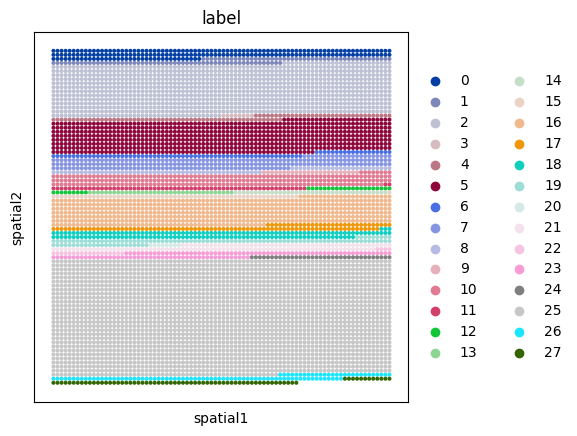

In [3]:
adata_sim = sc.AnnData(X1)
adata_sim.obs['label'] = pd.Categorical(y)
adata_sim.obsm['spatial'] = pos
sc.pl.spatial(adata_sim, color='label', spot_size=1)

Build the SMOPCA model and inference parameters.

In [4]:
X1, X2 = preprocess_hvg(x_list=[X1, X2], select_list=[True, False], top=1000)
print(X1.shape, X2.shape)
smopca = SMOPCA(Y_list=[X1.T, X2.T], Z_dim=20, pos=pos, intercept=False)
smopca.estimateParams(sigma_init_list=(1, 1), tol_sigma=2e-5, sigma_xtol_list=(1e-6, 1e-6),
                      gamma_init=1, estimate_gamma=True, iterations_gamma=1, gamma_bound=(1, 10), gamma_tol=1)
z = smopca.calculatePosterior()
y_pred = KMeans(n_clusters=28, n_init=100).fit_predict(z)
ami, nmi, ari = clustering_metric(y, y_pred)
print("AMI={}, NMI={}, ARI={}".format(ami, nmi, ari))

selecting top 1000 hvg for modality 1
Chosen offset: 0.19
normalizing counts


INFO:src.SMOPCA:SMOPCA object created, with 6949 cells and [1000, 110] features and matern kernel
INFO:src.SMOPCA:start estimating parameters, this will take a while...
INFO:src.SMOPCA:calculating matern kernel, nu = 1.5, length_scale = 1


(6949, 1000) (6949, 110)


INFO:src.SMOPCA:estimating sigma1
INFO:src.SMOPCA:sigma1 using bound: (0.80000, 0.90000)
INFO:src.SMOPCA:iter 0 sigma1 brentq done, sigma1sqr = 1.00000, sigma1hatsqr = 0.84808
INFO:src.SMOPCA:iter 1 sigma1 brentq done, sigma1sqr = 0.84808, sigma1hatsqr = 0.84800
INFO:src.SMOPCA:iter 2 sigma1 brentq done, sigma1sqr = 0.84800, sigma1hatsqr = 0.84800
INFO:src.SMOPCA:reach tolerance threshold, sigma1 done!
INFO:src.SMOPCA:estimating sigma2
INFO:src.SMOPCA:sigma2 using bound: (0.60000, 0.70000)
INFO:src.SMOPCA:iter 0 sigma2 brentq done, sigma2sqr = 1.00000, sigma2hatsqr = 0.62497
INFO:src.SMOPCA:iter 1 sigma2 brentq done, sigma2sqr = 0.62497, sigma2hatsqr = 0.62464
INFO:src.SMOPCA:iter 2 sigma2 brentq done, sigma2sqr = 0.62464, sigma2hatsqr = 0.62464
INFO:src.SMOPCA:reach tolerance threshold, sigma2 done!
INFO:src.SMOPCA:iter 0 gamma minimize done, gamma = 1.00000, gamma_hat = 1.47820
INFO:src.SMOPCA:calculating matern kernel, nu = 1.5, length_scale = 1.4781961335426104
INFO:src.SMOPCA:esti

AMI=0.78824, NMI=0.79262, ARI=0.63604


Visualize the latent space using UMAP.

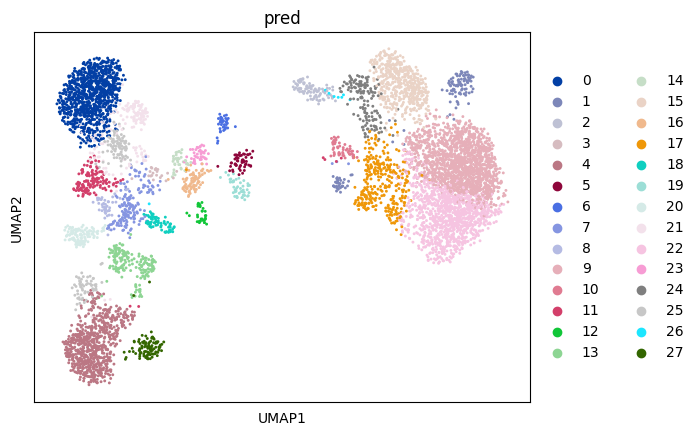

In [7]:
adata_res = sc.AnnData(z)
adata_res.obs['pred'] = pd.Categorical(y_pred)
sc.pp.neighbors(adata_res, n_neighbors=100, use_rep='X', metric='euclidean')
sc.tl.umap(adata_res, min_dist=1)
sc.pl.umap(adata_res, color='pred')